### Model Governance Notebook for models with and without the GLLD feature - OOT Mar
with and without `giact_last_link_date`

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import scale_scores
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [2]:
with open('../../models/customer_risk_target_from_gitlab.pkl', 'rb') as f:
    model_w_glld = pickle.load(f)
    
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    model_wo_glld = pickle.load(f)

### Data Processing

In [3]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 'giact_time_since_last_link', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

## OOT Data
---

In [4]:
modeling_df = pd.read_feather('../../artifacts/oot_unscored_2020-03-15.feather')

# how thomas did it..
# date = '2020-03-15'
# modeling_df = pd.read_feather('../../artifacts/sampled_df_raw_labeled_20200623.feather')
# modeling_df = modeling_df[modeling_df['sample_date'] == pd.to_datetime(date)]
# modeling_df['age_money_account'] = (modeling_df['sample_date'] - modeling_df['date_account_opened']).dt.days
modeling_df = preprocess(modeling_df)

# OOT
modeling_df['pred_wo_glld'] = model_wo_glld.predict_proba(modeling_df[model_wo_glld.feature_name_])[:, 1]
modeling_df['score_wo_glld'] = scale_scores(modeling_df['pred_wo_glld'])

modeling_df['pred_w_glld'] = model_w_glld.predict_proba(modeling_df[model_w_glld.feature_name_])[:, 1]
modeling_df['score_w_glld'] = scale_scores(modeling_df['pred_w_glld'])

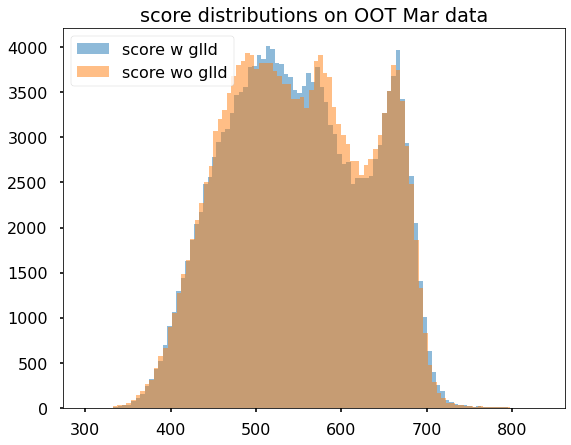

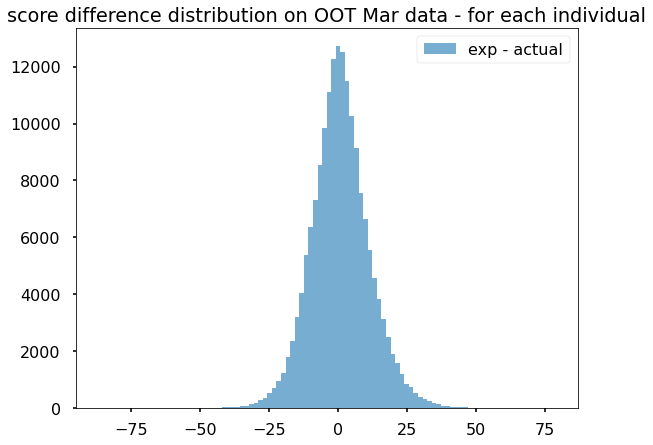

In [5]:
score_dist_plot = plot_score_dist(modeling_df.score_w_glld, 
                                  modeling_df.score_wo_glld, 
                                  bins=100, 
                                  dev_label='score w glld',
                                  prod_label='score wo glld',
                                  title='score distributions on OOT Mar data')
score_diff_plot = plot_difference(modeling_df.score_w_glld, 
                                  modeling_df.score_wo_glld, bins=100, 
                                  title='score difference distribution on OOT Mar data - for each individual')

In [6]:
score_diff_plot.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-mar/oot_score_diff_plot.png')
score_dist_plot.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-mar/oot_score_dist_plot.png')

### Risk Groups

In [7]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

modeling_df['risk_group_w_glld'] = get_risk_groups(modeling_df.score_w_glld)
modeling_df['risk_group_wo_glld'] = get_risk_groups(modeling_df.score_wo_glld)

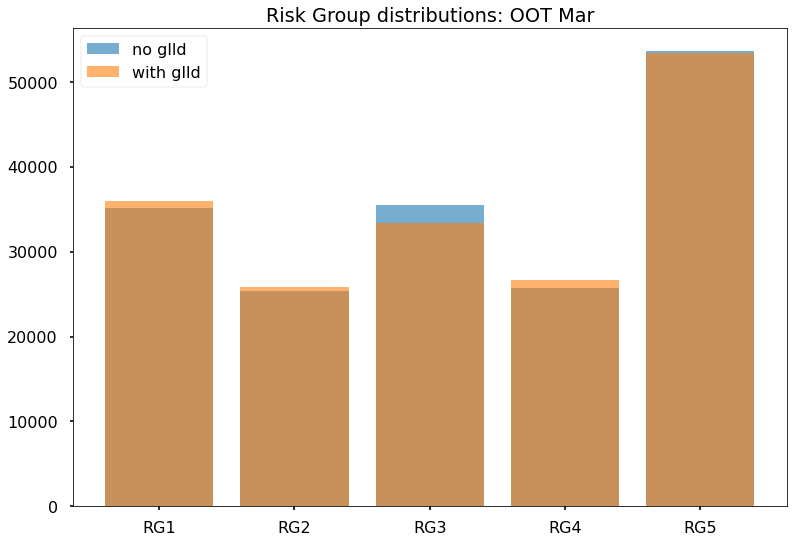

In [8]:
fig = plt.figure()
data = modeling_df.risk_group_w_glld.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='no glld')
data = modeling_df.risk_group_wo_glld.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='with glld')
plt.legend()
plt.title('Risk Group distributions: OOT Mar')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-mar/oot_risk_group_distr.png')

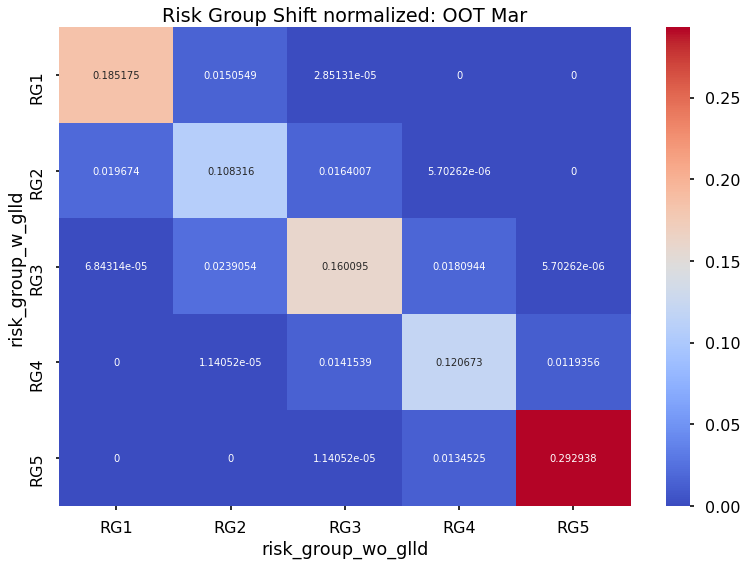

In [9]:
# compare the flow of risk groups
table = modeling_df[['risk_group_w_glld', 'risk_group_wo_glld']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['risk_group_w_glld', 'risk_group_wo_glld', 'counts']
table = pd.pivot_table(table, values='counts', index='risk_group_w_glld', 
                       columns='risk_group_wo_glld', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift normalized: OOT Mar')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-mar/oot_RG_shift_norm.png')

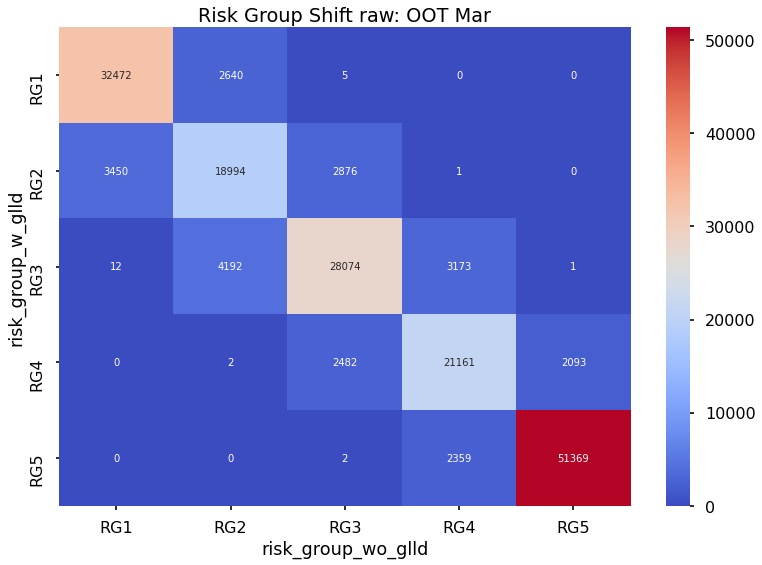

In [10]:
# compare the flow of risk groups
table = modeling_df[['risk_group_w_glld', 'risk_group_wo_glld']].value_counts().sort_index().reset_index()
table.columns = ['risk_group_w_glld', 'risk_group_wo_glld', 'counts']
table = pd.pivot_table(table, values='counts', index='risk_group_w_glld', 
                       columns='risk_group_wo_glld', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift raw: OOT Mar')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-mar/oot_RG_shift_raw.png')

### Statistic Tables

In [11]:
from rdsutils.plot import plot_pr_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
import gc

def build_table1(modeling_df, percentiles, target_col_name, pred_col_name):
    """ cumulative """
    df = []
    for thresh, pctl in [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles]:
        pred = modeling_df[pred_col_name] >= thresh
        rep = classification_report(y_true=modeling_df[target_col_name], y_pred=pred, output_dict=True)
        conf = confusion_matrix(y_true=modeling_df[target_col_name], y_pred=pred)
        tn, fp, fn, tp = conf.ravel()
        df.append([pctl, thresh, fp / (fp + tn) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[1][0], conf[0][1], tn])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', '#Fraudulent Above Threshold', 
                                     '#Fraudulent Below Threshold', '#Good Above Threshold', '#True Negatives'])

def get_metrics(df, score_col):
    dsigma = df[~df['fraud_score_2'].isna()]
    auc = round(roc_auc_score(y_score=dsigma['fraud_score_2'], 
                              y_true=dsigma['target'])*100, 2)
    ap = round(average_precision_score(y_score=dsigma['fraud_score_2'], 
                                       y_true=dsigma['target'])*100, 2)

    print(f'fraud_score_2 alone: {auc}, {ap}')
    del dsigma
    gc.collect()

    dfico = df[~df['fico_score'].isna()]
    auc = round(roc_auc_score(y_score=850-dfico['fico_score'], 
                              y_true=dfico['target'])*100, 2)
    ap = round(average_precision_score(y_score=850-dfico['fico_score'], 
                                       y_true=dfico['target'])*100, 2)

    print(f'fico alone: {auc}, {ap}')
    del dfico
    gc.collect()

    auc = round(roc_auc_score(y_score=df[score_col], 
                              y_true=df['target'])*100, 2)
    ap = round(average_precision_score(y_score=df[score_col], 
                                       y_true=df['target'])*100, 2)

    print(f'model perf: {auc}, {ap}')

#### OOT Stats

In [12]:
df_ = modeling_df[(modeling_df.nr_transactions_next_90d > 0) & (modeling_df.nr_past_transactions > 0)]
get_metrics(df_, 'pred_w_glld')

fraud_score_2 alone: 73.52, 4.04
fico alone: 70.44, 9.41
model perf: 95.85, 54.4


In [13]:
get_metrics(df_, 'pred_wo_glld')

fraud_score_2 alone: 73.52, 4.04
fico alone: 70.44, 9.41
model perf: 95.84, 53.15


#### OOT Tables

In [14]:
table = build_table1(modeling_df, np.linspace(90, 99, 10), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,90.0,0.74,9.65,56.84,17536,735,558,16801,157266
1,91.0,0.76,8.66,54.52,15783,705,588,15078,158989
2,92.0,0.77,7.67,51.89,14029,671,622,13358,160709
3,93.0,0.79,6.68,49.57,12276,641,652,11635,162432
4,94.0,0.80,5.70,46.56,10522,602,691,9920,164147
5,95.0,0.82,4.71,43.93,8768,568,725,8200,165867
6,96.0,0.83,3.72,41.22,7015,533,760,6482,167585
7,97.0,0.85,2.74,37.82,5261,489,804,4772,169295
8,98.0,0.87,1.76,34.18,3508,442,851,3066,171001
9,99.0,0.90,0.80,28.31,1754,366,927,1388,172679


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,0.74,9.65,56.84,17536,735,558,16801,157266
91.0,0.76,8.66,54.52,15783,705,588,15078,158989
92.0,0.77,7.67,51.89,14029,671,622,13358,160709
93.0,0.79,6.68,49.57,12276,641,652,11635,162432
94.0,0.8,5.7,46.56,10522,602,691,9920,164147
95.0,0.82,4.71,43.93,8768,568,725,8200,165867
96.0,0.83,3.72,41.22,7015,533,760,6482,167585
97.0,0.85,2.74,37.82,5261,489,804,4772,169295
98.0,0.87,1.76,34.18,3508,442,851,3066,171001
99.0,0.9,0.8,28.31,1754,366,927,1388,172679



In [15]:
table = build_table1(modeling_df, np.linspace(0, 90, 10), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,175360,1293,0,174067,0
1,10.0,0.00,89.93,99.69,157824,1289,4,156535,17532
2,20.0,0.01,79.86,98.99,140288,1280,13,139008,35059
3,30.0,0.01,69.79,98.22,122752,1270,23,121482,52585
4,40.0,0.03,59.73,96.91,105216,1253,40,103963,70104
5,50.0,0.06,49.66,95.44,87680,1234,59,86446,87621
6,60.0,0.14,39.61,92.65,70144,1198,95,68946,105121
7,70.0,0.27,29.57,87.78,52608,1135,158,51473,122594
8,80.0,0.53,19.58,76.02,35072,983,310,34089,139978
9,90.0,0.74,9.65,56.84,17536,735,558,16801,157266


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,175360,1293,0,174067,0
10.0,0.0,89.93,99.69,157824,1289,4,156535,17532
20.0,0.01,79.86,98.99,140288,1280,13,139008,35059
30.0,0.01,69.79,98.22,122752,1270,23,121482,52585
40.0,0.03,59.73,96.91,105216,1253,40,103963,70104
50.0,0.06,49.66,95.44,87680,1234,59,86446,87621
60.0,0.14,39.61,92.65,70144,1198,95,68946,105121
70.0,0.27,29.57,87.78,52608,1135,158,51473,122594
80.0,0.53,19.58,76.02,35072,983,310,34089,139978
90.0,0.74,9.65,56.84,17536,735,558,16801,157266



In [16]:
table = build_table1(modeling_df, np.linspace(0, 99, 100), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,175360,1293,0,174067,0
1,1.0,0.00,98.99,99.92,173606,1292,1,172314,1753
2,2.0,0.00,97.99,99.92,171852,1292,1,170560,3507
3,3.0,0.00,96.98,99.92,170099,1292,1,168807,5260
4,4.0,0.00,95.97,99.92,168345,1292,1,167053,7014
...,...,...,...,...,...,...,...,...,...
95,95.0,0.82,4.71,43.93,8768,568,725,8200,165867
96,96.0,0.83,3.72,41.22,7015,533,760,6482,167585
97,97.0,0.85,2.74,37.82,5261,489,804,4772,169295
98,98.0,0.87,1.76,34.18,3508,442,851,3066,171001


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,175360,1293,0,174067,0
1.0,0.0,98.99,99.92,173606,1292,1,172314,1753
2.0,0.0,97.99,99.92,171852,1292,1,170560,3507
3.0,0.0,96.98,99.92,170099,1292,1,168807,5260
4.0,0.0,95.97,99.92,168345,1292,1,167053,7014
5.0,0.0,94.96,99.92,166592,1292,1,165300,8767
6.0,0.0,93.96,99.85,164838,1291,2,163547,10520
7.0,0.0,92.95,99.85,163084,1291,2,161793,12274
8.0,0.0,91.94,99.85,161331,1291,2,160040,14027
9.0,0.0,90.93,99.77,159577,1290,3,158287,15780
10.0,0.0,89.93,99.69,157824,1289,4,156535,17532
11.0,0.0,88.92,99.69,156070,1289,4,154781,19286
12.0,0.0,87.91,99.69,154316,1289,4,153027,21040
13.0,0.0,86.91,99.61,152563,1288,5,151275,22792
14.0,0.0,85.9,99.46,150809,1286,7,149523,24544
15.0,0.0,84.89,99.38,149056,1285,8,147771,26296
16.0,0.0,83.89,99.3,147302,1284,9,146018,28049
17.0,0.0,82.88,99.3,145548

### Build Excel Tables

In [17]:
def build_table_3(modeling_df, percentiles, target_col_name, pred_col_name, fico_col_name):
    """ cumulative """
    df = []
    for (fthresh, pctl), (mthresh, pctl) in zip([(np.percentile(modeling_df[fico_col_name], pctl), pctl) for pctl in percentiles], [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles][::-1]):
        mbr = modeling_df[modeling_df[pred_col_name] >= mthresh]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name] <= fthresh]['target'].mean() * 100

        df.append([pctl, fthresh, mthresh, fbr, mbr])
        
    return pd.DataFrame(df, columns=['Percentile', 'FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])

def build_table_4(modeling_df, percentiles, target_col_name, pred_col_name, fico_col_name):
    """ interval """
    df = []
    
    fpctls = [(np.percentile(modeling_df[fico_col_name], pctl), pctl) for pctl in percentiles]
    mpctls = [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles][::-1]
    
    for i in range(0, len(fpctls) - 1):
        plo = fpctls[i][-1]
        phi = fpctls[i+1][-1]
        
        mbr = modeling_df[modeling_df[pred_col_name].between(mpctls[i+1][0], mpctls[i][0])]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name].between(fpctls[i][0], fpctls[i+1][0])]['target'].mean() * 100

        df.append([f'{plo}-{phi}', fpctls[i][0], mpctls[i+1][0], fbr, mbr])
        
    return pd.DataFrame(df, columns=['Percentile', 'FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])


def build_table_5(modeling_df, fico_thresholds, model_thresholds, target_col_name, pred_col_name, fico_col_name):
    """ consistent thresholds cumulative """
    df = []
    
    mx = modeling_df[pred_col_name].max()
    model_thresholds = [min(m, mx) for m in model_thresholds]
    
    for fthresh, mthresh in zip(fico_thresholds, model_thresholds):
        mbr = modeling_df[modeling_df[pred_col_name] >= mthresh]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name] <= fthresh]['target'].mean() * 100

        df.append([fthresh, mthresh, fbr, mbr])
        
    return pd.DataFrame(df, columns=['FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])


def build_table_6(modeling_df, fico_thresholds, model_thresholds, target_col_name, pred_col_name, fico_col_name):
    """ consistent thresholds interval """
    df = []
    
    mx = modeling_df[pred_col_name].max()
    model_thresholds = [min(m, mx) for m in model_thresholds]
    
    for i in range(0, len(fico_thresholds) - 1):
        mbr = modeling_df[modeling_df[pred_col_name].between(model_thresholds[i+1], model_thresholds[i], inclusive=True)]['target'].mean() * 100
        
        fbr = modeling_df[modeling_df[fico_col_name].between(fico_thresholds[i], fico_thresholds[i+1], inclusive=True)]['target'].mean() * 100

        df.append([f'{fico_thresholds[i]}-{fico_thresholds[i+1]}', f'{model_thresholds[i+1]}-{model_thresholds[i]}', fbr, mbr])
        
    return pd.DataFrame(df, columns=['FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])

### Verify - model with glld

In [18]:
fico_thresholds = [0, 479, 552, 582, 605, 630, 652, 671, 688, 702, 715, 726, 735, 743, 751, 759, 765, 772, 779, 786, 794, 801, 809, 818, 830, 850]
model_thresholds = [850, 637, 605, 580, 562, 547, 535, 525, 517, 509, 502, 495, 489, 483, 477, 471, 466, 460, 454, 448, 442, 434, 426, 416, 402, 300]

df_oot = modeling_df

dfixed = df_oot[~df_oot['fico_score'].isna()]
dfixed['fico_adjusted'] = dfixed['fico_score'] * np.where(dfixed['fico_score'] > 850, 0, 1)

tbl = build_table_3(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_4(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

tbl = build_table_5(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_6(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

print()
print('='*40)
print()

Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
100.0,0.0,831.87,11.81,100.0
96.0,479.0,636.96,13.27,28.3
92.0,551.0,604.41,12.31,16.7
88.0,581.0,579.29,9.8,11.74
84.0,604.0,560.56,8.11,9.09
80.0,628.0,545.92,6.8,7.34
76.0,651.0,533.82,5.81,6.17
72.0,670.0,523.78,5.11,5.35
68.0,687.0,515.23,4.52,4.71
64.0,701.0,507.36,4.05,4.21
60.0,714.0,500.36,3.68,3.81
56.0,725.0,493.74,3.34,3.47
52.0,734.0,487.63,3.09,3.19
48.0,743.0,481.59,2.86,2.95
44.0,751.0,475.87,2.67,2.74
40.0,758.0,470.11,2.52,2.56
36.0,765.0,464.28,2.37,2.42
32.0,772.0,458.75,2.23,2.28
28.0,779.0,453.08,2.12,2.16
24.0,786.0,447.02,2.01,2.04
20.0,793.0,440.67,1.92,1.94
16.0,800.0,433.49,1.83,1.85
12.0,809.0,425.65,1.75,1.77
8.0,818.0,415.78,1.69,1.69
4.0,830.0,401.55,1.62,1.62
0.0,850.0,306.7,1.56,1.56

----------------------------------------
Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
0.0-4.0,0.0,636.96,13.27,28.3
4.0-8.0,479.0,604.41,11.39,5.1
8.0

In [19]:
fico_thresholds = [0, 479, 552, 582, 605, 630, 652, 671, 688, 702, 715, 726, 735, 743, 751, 759, 765, 772, 779, 786, 794, 801, 809, 818, 830, 850]
model_thresholds = [850, 637, 605, 580, 562, 547, 535, 525, 517, 509, 502, 495, 489, 483, 477, 471, 466, 460, 454, 448, 442, 434, 426, 416, 402, 300]

df_oot = modeling_df

dfixed = df_oot[~df_oot['fico_score'].isna()]
dfixed['fico_adjusted'] = dfixed['fico_score'] * np.where(dfixed['fico_score'] > 850, 0, 1)

tbl = build_table_3(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_4(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

tbl = build_table_5(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_6(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

print()
print('='*40)
print()

Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
100.0,0.0,835.25,11.81,100.0
96.0,479.0,637.81,13.27,28.16
92.0,551.0,605.14,12.31,16.65
88.0,581.0,579.47,9.8,11.82
84.0,604.0,560.77,8.11,9.09
80.0,628.0,546.13,6.8,7.37
76.0,651.0,534.07,5.81,6.23
72.0,670.0,523.7,5.11,5.35
68.0,687.0,515.11,4.52,4.7
64.0,701.0,507.28,4.05,4.21
60.0,714.0,500.07,3.68,3.8
56.0,725.0,493.59,3.34,3.47
52.0,734.0,487.48,3.09,3.19
48.0,743.0,481.69,2.86,2.95
44.0,751.0,476.16,2.67,2.74
40.0,758.0,470.62,2.52,2.56
36.0,765.0,465.2,2.37,2.41
32.0,772.0,459.57,2.23,2.27
28.0,779.0,453.92,2.12,2.15
24.0,786.0,448.01,2.01,2.04
20.0,793.0,441.73,1.92,1.94
16.0,800.0,434.6,1.83,1.85
12.0,809.0,426.5,1.75,1.77
8.0,818.0,416.35,1.69,1.69
4.0,830.0,401.83,1.62,1.62
0.0,850.0,300.0,1.56,1.56

----------------------------------------
Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
0.0-4.0,0.0,637.81,13.27,28.16
4.0-8.0,479.0,605.14,11.39,5.14
8.0-1